<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Trial-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import xarray as xr

stations = pd.read_csv('basePM25nearest_grid.csv')

stations.head()

,lon,lat,nearest_grid_lon,nearest_grid_lat,grid_cell_index,SURF_ug_PM25_rh50,nearest_SURF_ug_PM25_rh50
0,13.1945,46.9350,13.15,46.925,"(289, 282)",3.370927,3.208787
1,13.9145,46.6954,13.95,46.675,"(284, 290)",6.053020,5.893659
2,14.4574,46.8666,14.45,46.875,"(288, 295)",5.833692,5.619751
3,16.0625,48.3294,16.05,48.325,"(317, 311)",9.499794,8.903049
4,16.3315,48.1247,16.35,48.125,"(313, 314)",10.630700,10.086845


In [17]:
pip install cartopy

In [18]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.0 MB/s eta 0:00:00


# Machine Learning-


## Random Forest

Random Forest Evaluation:
MAE: 0.263
RMSE: 0.598
R² Score: 0.983


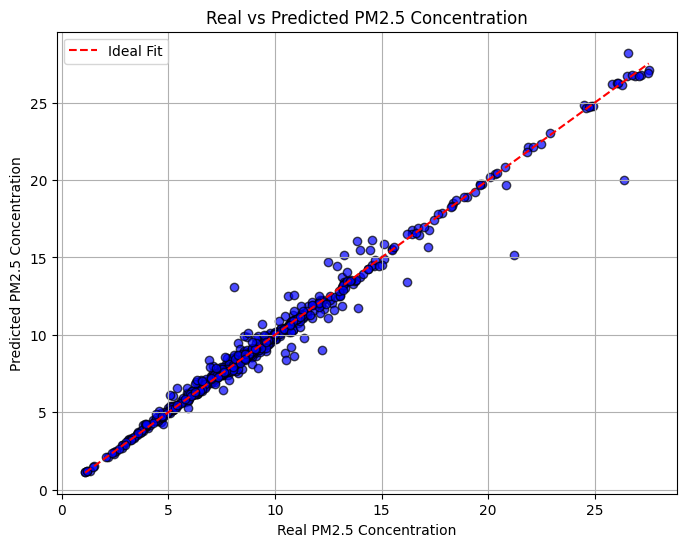

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Η διαδικασία ολοκληρώθηκε! Το διορθωμένο αρχείο αποθηκεύτηκε ως 'corrected_RandomForestRegressor_PM25.nc'


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


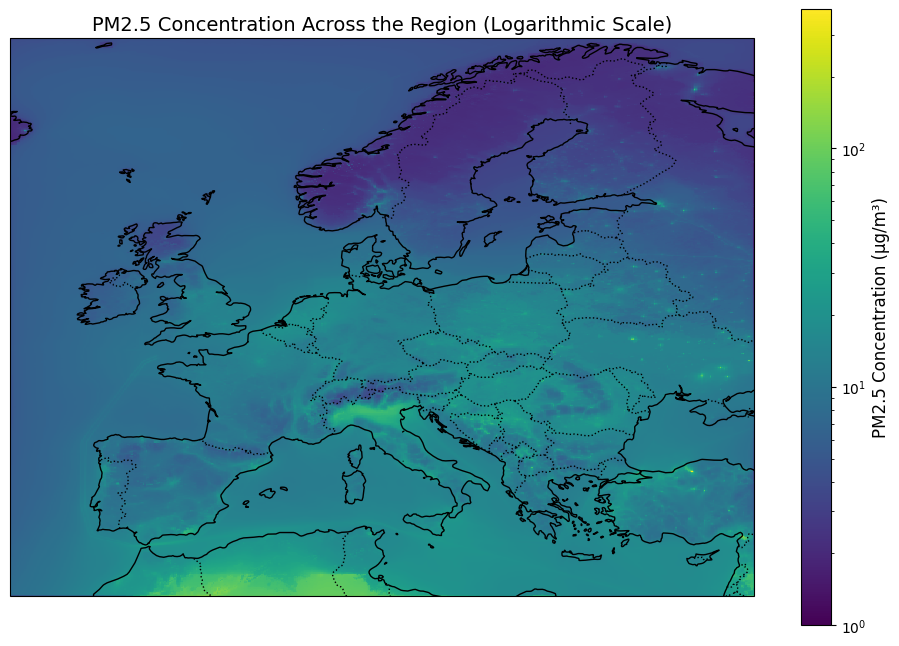

In [6]:
import pandas as pd
import xarray as xr
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Φόρτωση των δεδομένων
nc_data = xr.open_dataset('BaseCase_PERT_PM25_rh50_YEARLY.nc')

# Φόρτωση δεδομένων
csv_path = "basePM25nearest_grid.csv"
stations = pd.read_csv(csv_path)

# Δημιουργία feature matrix
X = stations[['lon', 'lat', 'nearest_SURF_ug_PM25_rh50']]
y = stations['SURF_ug_PM25_rh50']  # Πραγματικές τιμές (Observed)

# Διαχωρισμός σε training και test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Εκπαίδευση Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15, min_samples_split=10)
model.fit(X_train, y_train)

# Πρόβλεψη για το test set
y_pred = model.predict(X_test)

# Υπολογισμός των μετρικών σφάλματος
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Εκτύπωση αποτελεσμάτων
print(f"Random Forest Evaluation:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# Δημιουργία scatter plot για τη σύγκριση πραγματικών και προβλεπόμενων τιμών
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.title('Real vs Predicted PM2.5 Concentration')
plt.xlabel('Real PM2.5 Concentration')
plt.ylabel('Predicted PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.show()

# Δημιουργία πλέγματος για το NetCDF
grid_lon, grid_lat = np.meshgrid(nc_data['lon'].values, nc_data['lat'].values)

# Προετοιμασία των grid features για πρόβλεψη
grid_PM25 = nc_data['SURF_ug_PM25_rh50'].values
grid_features = np.column_stack([grid_lon.ravel(), grid_lat.ravel(), grid_PM25.ravel()])

# Πρόβλεψη bias correction
predicted_correction = model.predict(grid_features).reshape(grid_lon.shape)

# Προσθήκη στο NetCDF
nc_data['bias_correction'] = (('lat', 'lon'), predicted_correction)
nc_data['corrected_concentration'] = nc_data['SURF_ug_PM25_rh50'] + nc_data['bias_correction']

# Αποθήκευση του διορθωμένου NetCDF
nc_data.to_netcdf('corrected_RandomForestRegressor_PM25.nc')

print("Η διαδικασία ολοκληρώθηκε! Το διορθωμένο αρχείο αποθηκεύτηκε ως 'corrected_RandomForestRegressor_PM25.nc'")

# Προβολή του διορθωμένου NetCDF
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.colors as mcolors

# Φόρτωση του διορθωμένου NetCDF
file_path = 'corrected_RandomForestRegressor_PM25.nc'
nc_data = xr.open_dataset(file_path)

# Εξαγωγή δεδομένων για οπτικοποίηση
lon = nc_data['lon'].values  # Συντεταγμένες μήκους
lat = nc_data['lat'].values  # Συντεταγμένες πλάτους
PM25 = nc_data['corrected_concentration'].isel(time=0).values  # Επιλογή δεδομένων PM2.5

# Δημιουργία πλέγματος (meshgrid) για τις συντεταγμένες
Lon, Lat = np.meshgrid(lon, lat)

# Ορισμός λογαριθμικής κλίμακας
norm = mcolors.LogNorm(vmin=1, vmax=np.nanmax(PM25))  # Λογαριθμική κανονικοποίηση

# Δημιουργία χάρτη με προβολή PlateCarree
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Οπτικοποίηση των δεδομένων PM2.5 με pcolormesh και λογαριθμική κλίμακα
mesh = ax.pcolormesh(Lon, Lat, PM25, cmap='viridis', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Προσθήκη γραμμής χρωμάτων (colorbar)
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('PM2.5 Concentration (µg/m³)', fontsize=12)

# Προσθήκη γεωγραφικών χαρακτηριστικών (ακτογραμμές και σύνορα)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Τίτλος και εμφάνιση του χάρτη
plt.title('PM2.5 Concentration Across the Region (Logarithmic Scale)', fontsize=14)
plt.show()
